# Examples showcasing GEM EO BYOC data collections

This is a notebook showcasing workflow examples for downloading EO data from BYOC data collections available through Sentinel Hub.

### Data download examples in this notebook:

1.  Sentinel-2 L2A mosaic for Africa

2.  Meteoblue weather data for Africa


In [1]:
%matplotlib inline

import math

import matplotlib.pyplot as plt
import numpy as np

from eolearn.core import FeatureType
from eolearn.io import SentinelHubEvalscriptTask
from sentinelhub import CRS, Band, BBox, DataCollection, Unit

In [2]:
bbox = BBox(bbox=[-18, 1, 27.5, 28], crs=CRS.WGS84)

In [3]:
def evalscript_template(bands, sample_type):
    evaluate_pixel = ", ".join(f"sample.{band}" for band in bands)
    return f"""
    //VERSION=3
    function setup() {{
      return {{
        input: {bands},
        output: [
            {{
              id: "bands",
              bands: {len(bands)},
              sampleType: "{sample_type}"
            }}
        ]
      }};
    }}
    function evaluatePixel(sample) {{
      return [{evaluate_pixel}];
    }}
    """

## Sentinel-2 L2A mosaic for Africa

In [4]:
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A"]

africa_s2_data_collection = DataCollection.define_byoc(
    "fe60e85f-0648-4c54-b2dc-bbf725033813",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.uint16,)) for name in band_names],
)

In [5]:
download_task = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(band_names, "UINT16"),
    data_collection=africa_s2_data_collection,
    resolution=5000,
    max_threads=3,
)

In [6]:
eopatch = download_task.execute(bbox=bbox, time_interval=["2020-08-01", "2020-08-30"])

In [7]:
eopatch

EOPatch(
  data={
    bands: numpy.ndarray(shape=(1, 647, 968, 12), dtype=uint16)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-08-01T00:00:00', '2020-08-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 8, 1, 0, 0)]
)

In [8]:
def plot(title, names, data):
    ncols = 3
    nrows = math.ceil(len(data) / 3)

    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 4 * nrows))
    fig.suptitle(title, y=0.93, size=16)

    for idx, _ in enumerate(data):
        ax[idx // ncols][idx % ncols].imshow(data[idx])
        ax[idx // ncols][idx % ncols].set_title(names[idx], size=12)
        ax[idx // ncols][idx % ncols].get_xaxis().set_visible(False)
        ax[idx // ncols][idx % ncols].get_yaxis().set_visible(False)

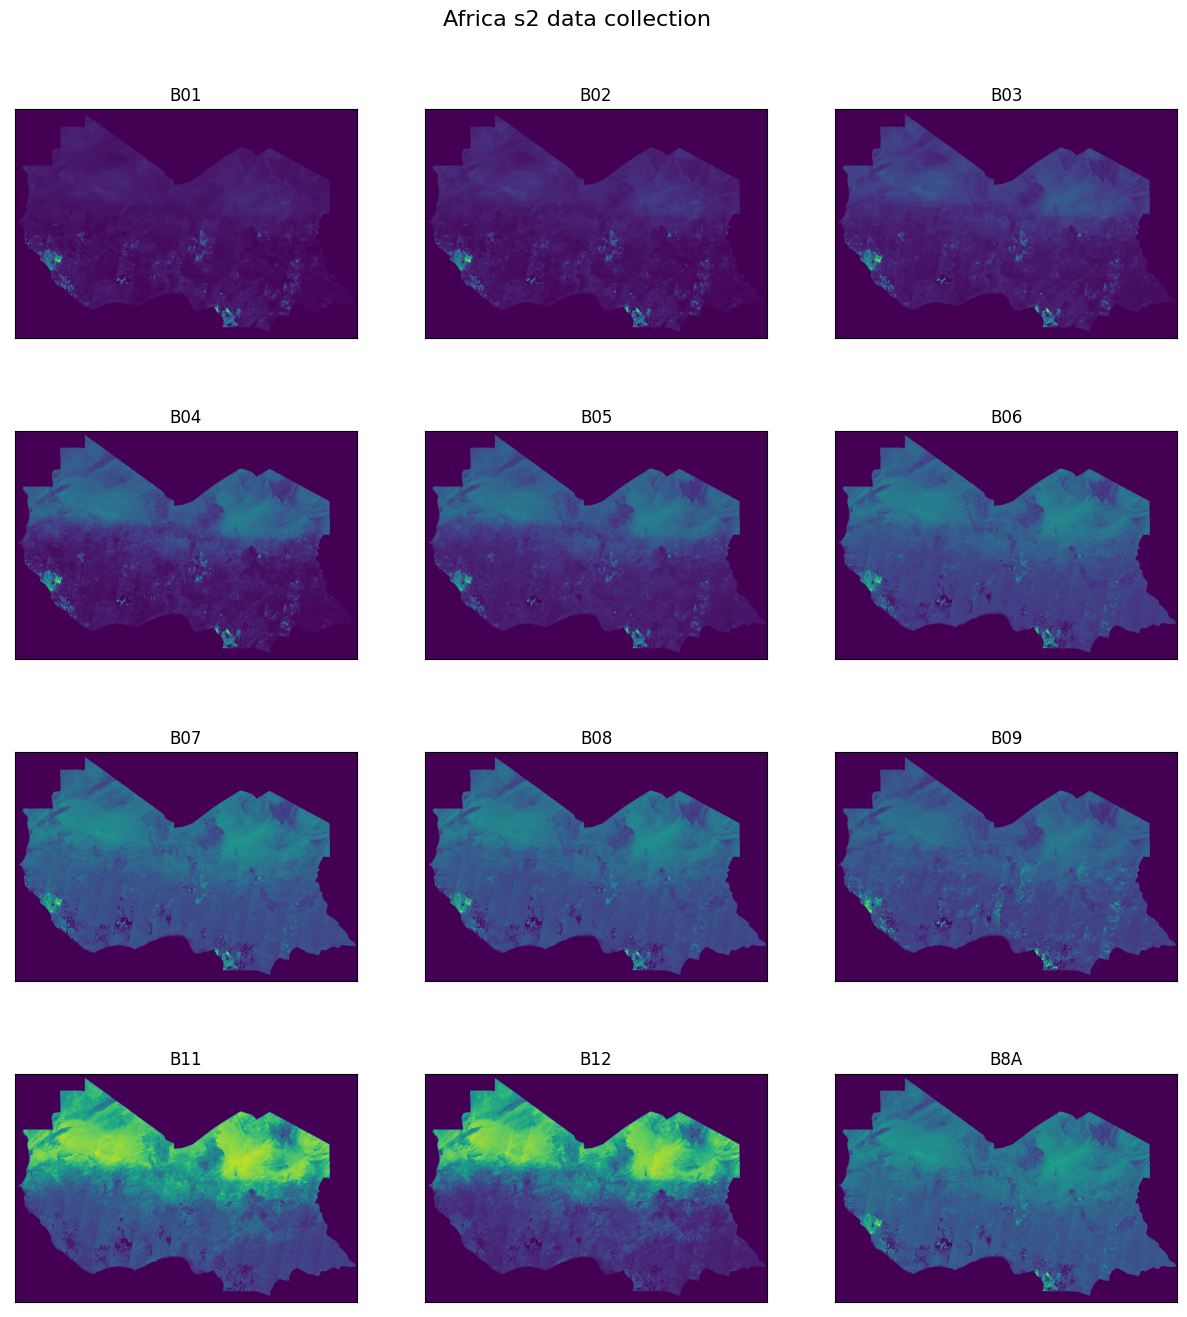

In [9]:
plot(
    "Africa s2 data collection",
    band_names,
    [eopatch.data["bands"][0][..., idx].squeeze() for idx, _ in enumerate(band_names)],
)

In [10]:
download_task_true_color = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(["B02", "B03", "B04"], "UINT16"),
    data_collection=africa_s2_data_collection,
    resolution=5000,
    max_threads=3,
)

In [11]:
eopatch_true_color = download_task_true_color.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-30"])

In [12]:
eopatch_true_color

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 647, 968, 3), dtype=uint16)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-01-01T00:00:00', '2020-12-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

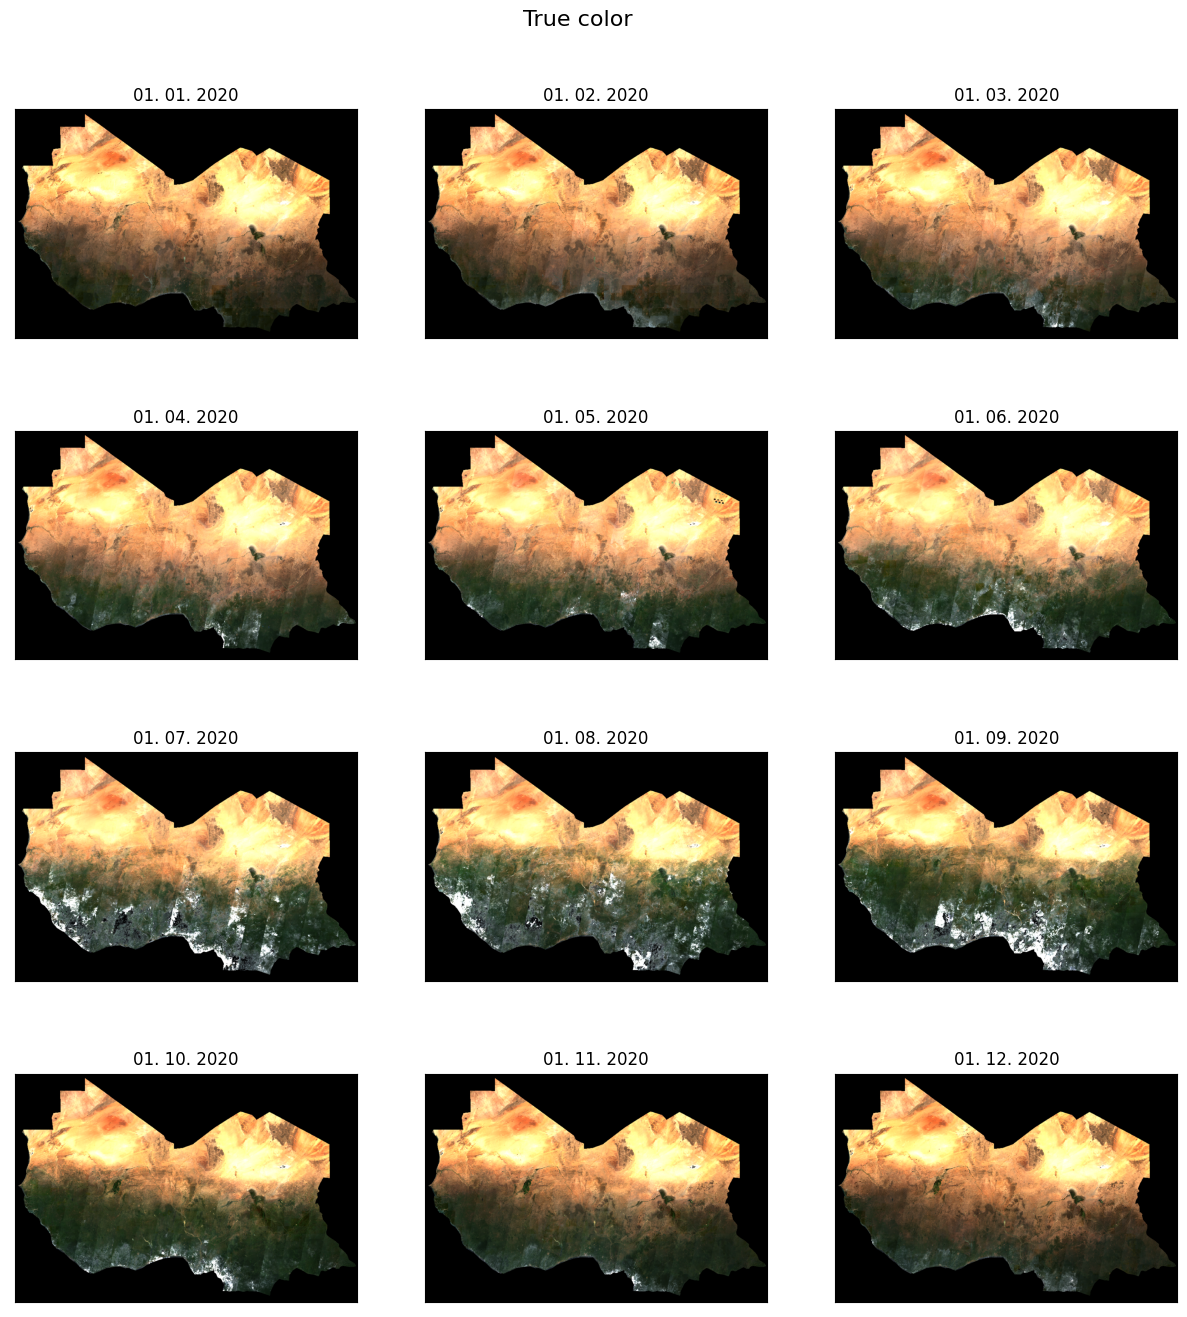

In [13]:
names_true_color = [time_stamp.strftime("%d. %m. %Y") for time_stamp in eopatch_true_color.timestamp]
data_true_color = [
    np.clip(eopatch_true_color.data["bands"][idx][..., [2, 1, 0]] / 10000 * 3, 0, 1)
    for idx, _ in enumerate(eopatch_true_color.timestamp)
]

plot("True color", names_true_color, data_true_color)

## Meteoblue weather data for Africa

In [14]:
band_names = [
    "CLOUD_COVER_TOTAL",
    "HUMIDITY",
    "PRECIPITATION",
    "PRESSURE",
    "SOIL_MOISTURE",
    "SUN_DURATION",
    "TEMPERATURE",
    "VAPOR_PRESSURE_DEFICIT",
    "WIND",
]

S2_africa_weather_data_collection = DataCollection.define_byoc(
    "0013507a-de28-4800-a890-394c493a51a3",
    service_url="https://services.sentinel-hub.com",
    bands=[Band(name=name, units=(Unit.DN,), output_types=(np.float32,)) for name in band_names],
)

In [15]:
download_task_weather = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(band_names, "FLOAT32"),
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [16]:
eopatch_weather = download_task_weather.execute(bbox=bbox, time_interval=["2020-08-01", "2020-08-30"])

In [17]:
eopatch_weather

EOPatch(
  data={
    bands: numpy.ndarray(shape=(1, 647, 968, 9), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-08-01T00:00:00', '2020-08-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 8, 1, 0, 0)]
)

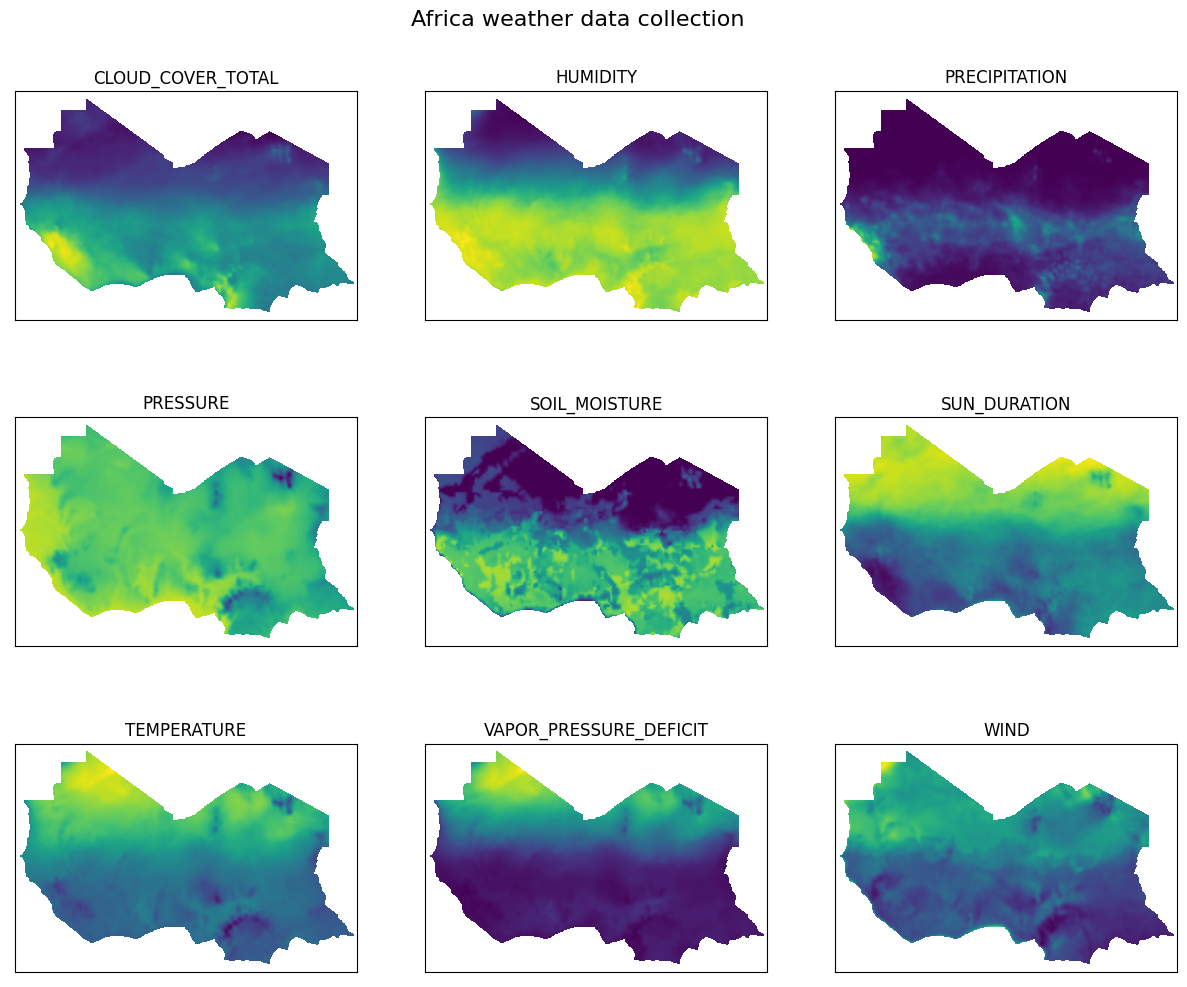

In [18]:
plot(
    "Africa weather data collection",
    band_names,
    [eopatch_weather.data["bands"][0][..., idx].squeeze() for idx, _ in enumerate(band_names)],
)

In [19]:
ps_download_task_precipitation = SentinelHubEvalscriptTask(
    features=(FeatureType.DATA, "bands"),
    evalscript=evalscript_template(["PRECIPITATION"], "FLOAT32"),
    data_collection=S2_africa_weather_data_collection,
    resolution=5000,
    max_threads=3,
)

In [20]:
eopatch_precipitation = ps_download_task_precipitation.execute(bbox=bbox, time_interval=["2020-01-01", "2020-12-30"])

In [21]:
eopatch_precipitation

EOPatch(
  data={
    bands: numpy.ndarray(shape=(12, 647, 968, 1), dtype=float32)
  }
  meta_info={
    size_x: 968
    size_y: 647
    time_difference: 1.0
    time_interval: ('2020-01-01T00:00:00', '2020-12-30T23:59:59')
  }
  bbox=BBox(((-18.0, 1.0), (27.5, 28.0)), crs=CRS('4326'))
  timestamp=[datetime.datetime(2020, 1, 1, 0, 0), ..., datetime.datetime(2020, 12, 1, 0, 0)], length=12
)

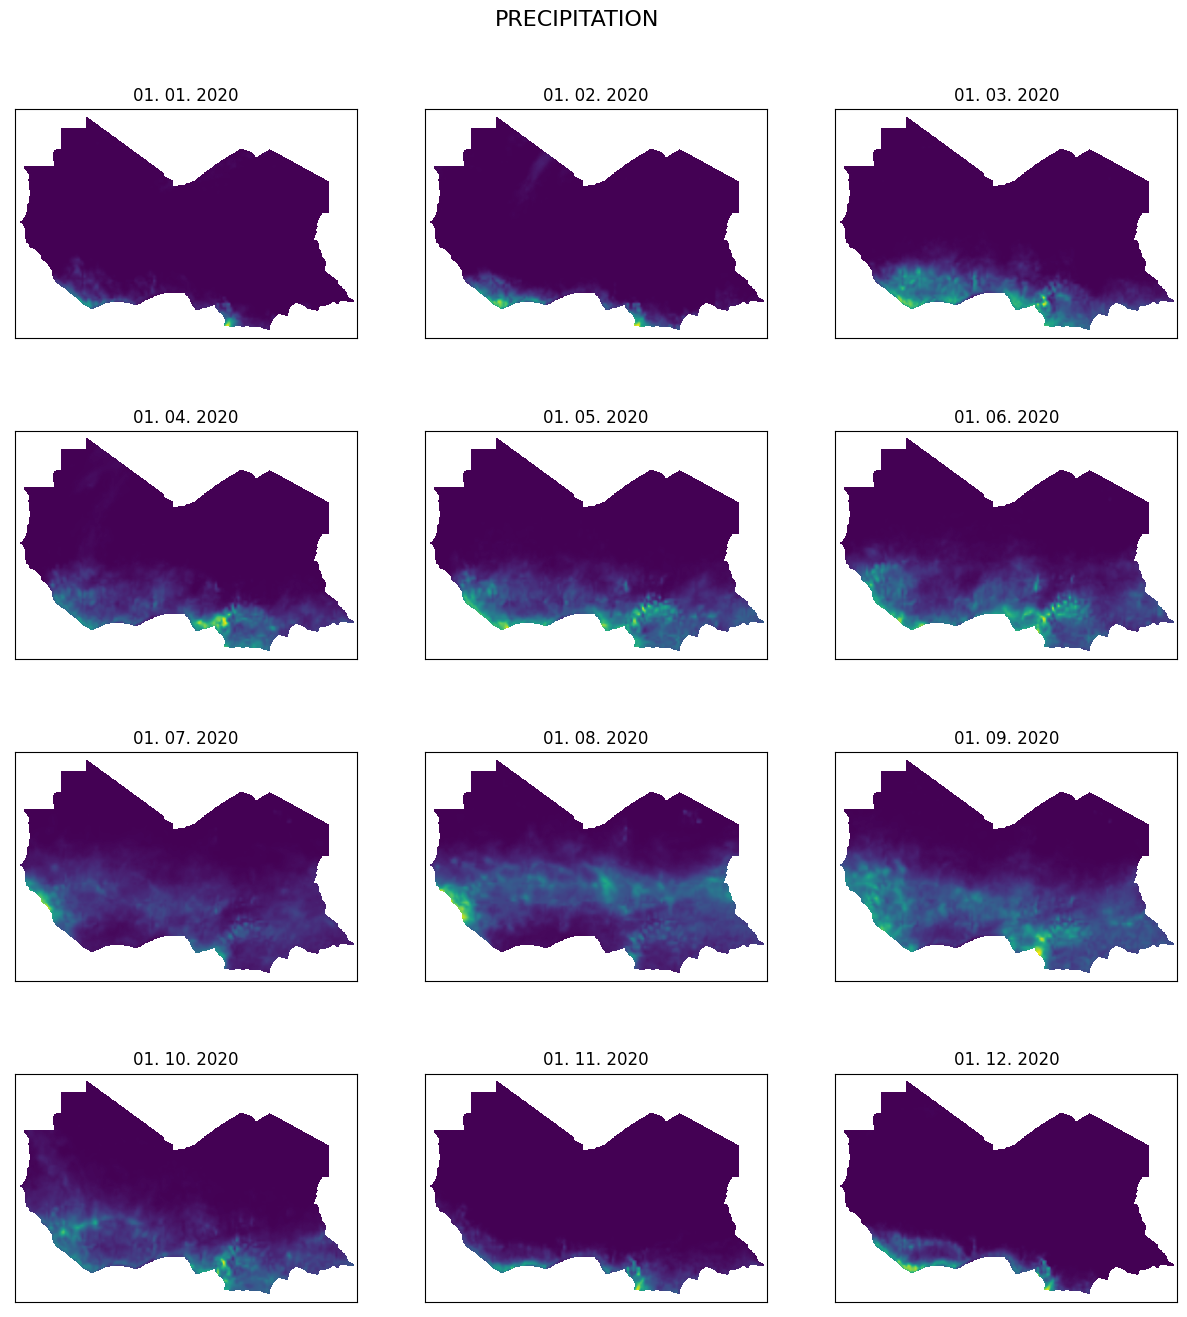

In [22]:
names_precipitation = [time_stamp.strftime("%d. %m. %Y") for time_stamp in eopatch_precipitation.timestamp]
data_precipitation = [
    eopatch_precipitation.data["bands"][idx][...] for idx, _ in enumerate(eopatch_precipitation.timestamp)
]

plot("PRECIPITATION", names_precipitation, data_precipitation)